# Setup

In [1]:
from dask.distributed import Client

client = Client("tls://192.168.86.23:8786")
client

Connection method: Direct,
Dashboard: /user/noah.alexander.zipper@cern.ch/proxy/8787/status,
Comm: tls://192.168.86.23:8786,Workers: 0
Dashboard: /user/noah.alexander.zipper@cern.ch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [32]:
import numpy as np
import awkward as ak
import hist
from coffea import processor
from pprint import pprint

class ScoreHist(processor.ProcessorABC):
    def __init__(self, bins=None, trigger_path='', extra_cut=''):
        self.trigger_path = trigger_path
        self.extra_cut = extra_cut
        self.bins = bins if bins else (1000,0,1000) 

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = {'start': len(events)}
        hist_dict = {}
        axo = events.axol1tl
        
        h = hist.Hist.new \
            .Reg(*self.bins, label='Anomaly Score') \
            .Double() \
            .fill(axo.score)
        hist_dict['anomaly_score'] = h
    
        if self.trigger_path:
            # require trigger
            isL1 = True if self.trigger_path.startswith('L1') else False
            trig_br = getattr(events, 'L1' if isL1 else 'HLT')
            trig_path = self.trigger_path.split('L1_' if isL1 else 'HLT_')[1]
            events = events[
                getattr(trig_br,trig_path)
            ]
            cutflow['trigger'] = len(events)
            axo = events.axol1tl

            h = hist.Hist.new \
                .Reg(*self.bins, label='Anomaly Score') \
                .Double() \
                .fill(axo.score)
            hist_dict[f'anomaly_score_{self.trigger_path}'] = h
        
        return {
            dataset: {
                'entries': len(events),
                'cutflow': cutflow,
                'hists' : hist_dict,
            }
        }
    
    def postprocess(self, accumulator):
        return accumulator
    
class KinematicHists(processor.ProcessorABC):
    def __init__(self, trigger_path='', extra_cut=''):
        self.run_dict = {
            'thresholds' : {
                '100hz' : {'name'  : '100 Hz', 'score' : 1280.375},
                '1khz'  : {'name'  : '1 kHz', 'score' : 982.3125},
                '5khz'  : {'name'  : '5 kHz', 'score' : 734.8125},
                '10khz' : {'name'  : '10 kHz', 'score' : 610.8125},
                'nocut' : {'name'  : 'Raw', 'score' : -100.},
            },
            'labels' : {'Jet' : 
                            {'label' : 'j'},
                        'Electron' : 
                            {'label' : 'e'},
                        'Muon' : 
                            {'label' : '\mu'},
                       }
        }

        self.sorted_keys = sorted(self.run_dict['thresholds'], key=lambda i: self.run_dict['thresholds'][i]['score'])
        self.trigger_path = trigger_path
        self.extra_cut = extra_cut

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = {'start': len(events)}

        if self.trigger_path:
            # require trigger
            isL1 = True if self.trigger_path.startswith('L1') else False
            trig_br = getattr(events, 'L1' if isL1 else 'HLT')
            trig_path = self.trigger_path.split('L1_' if isL1 else 'HLT_')[1]
            events = events[
                getattr(trig_br,trig_path)
            ]
            cutflow['trigger'] = len(events)
        
       
        
        hist_dict = {}
        for k in self.sorted_keys:
            axo = events.axol1tl
            events = events[axo.score >= self.run_dict['thresholds'][k]['score']]
            cutflow[f'score_{k}'] = len(events)
            
            for obj,label_dict in self.run_dict['labels'].items():
                col = getattr(events, obj)
                print(dir(col))
                h_pt = hist.Hist.new \
                    .Reg(100,0,100, label='$p_{t}('+label_dict['label']+')$ [GeV]') \
                    .Double() \
                    .fill(col.pt)
                hist_dict[f'pt_{obj}_{k}'] = h_pt
                
                h_eta = hist.Hist.new \
                    .Reg(20,-4,4, label='$\eta('+label_dict['label']+')$') \
                    .Double() \
                    .fill(col.eta)
                hist_dict[f'eta_{obj}_{k}'] = h_eta
                
                h_phi = hist.Hist.new \
                    .Reg(20,-4,4, label='$\phi('+label_dict['label']+')$') \
                    .Double() \
                    .fill(col.phi)
                hist_dict[f'phi_{obj}_{k}'] = h_phi                
                    
        return {
            dataset: {
                'entries': len(events),
                'cutflow': cutflow,
                'hists' : hist_dict,
            }
        }

    def postprocess(self, accumulator):
        return accumulator

class DiObjectMass(processor.ProcessorABC):
    def __init__(self, object_1='Jet', object_2='Jet', bins=None, trigger_path='', extra_cut=''):
        self.run_dict = {
            'thresholds' : {
                '100hz' : {'name'  : '100 Hz', 'score' : 1280.375},
                '1khz'  : {'name'  : '1 kHz', 'score' : 982.3125},
                '5khz'  : {'name'  : '5 kHz', 'score' : 734.8125},
                '10khz' : {'name'  : '10 kHz', 'score' : 610.8125},
                'nocut' : {'name'  : 'Raw', 'score' : -100.},
            },
            'labels' : {'Jet' : 
                            {'label' : 'j'},
                        'Electron' : 
                            {'label' : 'e'},
                        'Muon' : 
                            {'label' : '\mu'},
                       }
        }

        self.sorted_keys = sorted(self.run_dict['thresholds'], key=lambda i: self.run_dict['thresholds'][i]['score'])
        self.isSame = object_1==object_2
        self.object_1 = object_1
        self.object_2 = object_2
        self.extra_cut = extra_cut
        self.bins = bins if bins else (1000,0,1000) 

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = {'start': len(events)}

        # # require trigger
        # events = events[
        #     # https://twiki.cern.ch/twiki/bin/view/CMS/MuonHLT2018
        #     events.HLT.Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8
        # ]
        # cutflow['trigger'] = len(events)
        
        events['obj1'] = getattr(events, self.object_1)
        events['obj2'] = getattr(events, self.object_2)
       
        diObjMask = (ak.num(events.obj1) >= 2) if self.isSame else ((ak.num(events.obj1) >= 1) & (ak.num(events.obj2) >= 1))
        events = events[diObjMask]
        cutflow['diObj'] = len(events)
        
        events['diObj'] = events.obj1[:, 0] + (events.obj1[:, 1] if self.isSame else events.obj2[:, 0])
        
        hist_dict = {}
        for k in self.sorted_keys:
            axo = events.axol1tl
            events = events[axo.score >= self.run_dict['thresholds'][k]['score']]
            cutflow[f'score_{k}'] = len(events)
            
            h = hist.Hist.new \
                .Reg(*self.bins, label='$m_{'+self.run_dict['labels'][self.object_1]['label']+self.run_dict['labels'][self.object_2]['label']+'}$ [GeV]') \
                .Double() \
                .fill(events.diObj.mass)
            hist_dict[f'm{self.object_1}{self.object_2}_{k}'] = h
                    
        return {
            dataset: {
                'entries': len(events),
                'cutflow': cutflow,
                'hists' : hist_dict,
            }
        }

    def postprocess(self, accumulator):
        return accumulator
        
proc_args = {'schema': processor.NanoAODSchema}#, 'client': client}

# Processing

In [33]:
# Di-Jet Mass

mjj_result = processor.run_uproot_job(
    evts,
    'Events',
    DiObjectMass(object_1='Jet', object_2='Jet', bins=(40,0,2000)),
    processor.dask_executor,
    proc_args,
    chunksize=5000,
)
pprint(mjj_result)

Output()

['E', 'LOOSE', 'Mask', 'PNetRegPtRawCorr', 'PNetRegPtRawCorrNeutrino', 'PNetRegPtRawRes', 'TIGHT', 'TIGHTLEPVETO', 
'__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', 
'__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', 
'__reduce_ex__', '__repr__', '__self__', '__self_class__', '__setattr__', '__sizeof__', '__str__', 
'__subclasshook__', '__thisclass__', '_behavior', '_caches', '_layout', '_numbaview', 'absolute', 'add', 
'add_kind', 'add_systematic', 'area', 'behavior', 'boost', 'boostvec', 'btagDeepFlavB', 'btagDeepFlavCvB', 
'btagDeepFlavCvL', 'btagDeepFlavQG', 'btagPNetB', 'btagPNetCvB', 'btagPNetCvL', 'btagPNetQvG', 'btagPNetTauVJet', 
'btagRobustParTAK4B', 'btagRobustParTAK4CvB', 'btagRobustParTAK4CvL', 'btagRobustParTAK4QG', 'caches', 'chEmEF', 
'chHEF', 'chMultiplicity', 'constituents', 'cross', 'delta_phi', 'delta_r', 'delta_r2', 'describe_variations', 
'divide', 'dot', 'electronIdx1', 'electronIdx1G', 'electronIdx2', 'electronIdx2G', 'electronIdxG', 'energy', 'eta',
'explodes_how', 'fields', 'hfEmEF', 'hfHEF', 'hfadjacentEtaStripsSize', 'hfcentralEtaStripSize', 'hfsigmaEtaEta', 
'hfsigmaPhiPhi', 'isLoose', 'isTight', 'isTightLeptonVeto', 'jetId', 'layout', 'mask', 'mass', 'mass2', 
'matched_electrons', 'matched_gen', 'matched_muons', 'metric_table', 'muEF', 'multiply', 'muonIdx1', 'muonIdx1G', 
'muonIdx2', 'muonIdx2G', 'muonIdxG', 'muonSubtrFactor', 'nConstituents', 'nElectrons', 'nMuons', 'nSVs', 'nbytes', 
'ndim', 'neEmEF', 'neHEF', 'neMultiplicity', 'nearest', 'negative', 'numba_type', 'p', 'p2', 'phi', 'pt', 'pt2', 
'pvec', 'px', 'py', 'pz', 'r', 'r2', 'rawFactor', 'rho', 'rho2', 'slot0', 'slot1', 'slot2', 'slot3', 'slot4', 
'slot5', 'slot6', 'slot7', 'slot8', 'slot9', 'subtract', 'sum', 'svIdx1', 'svIdx2', 'systematics', 't', 'theta', 
'to_list', 'to_numpy', 'tolist', 'type', 'unit', 'x', 'y', 'z']

Exception: Failed processing file: WorkItem(dataset='JetMET0_slimmed', filename='root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2023_Data_Production-wScores/L1Nano_JetMET_slimmed_wAxol1tlV3Scores.root', treename='Events', entrystart=0, entrystop=5000, fileuuid=b'\xc5()@\xb00\x11\xee\xaa\x16\x90\xbd\xe1\x83\xbe\xef', usermeta={})

In [3]:
# Di-Muon Mass

mmumu_result = processor.run_uproot_job(
    'axol1tl_filelist.json',
    'Events',
    DiObjectMass(object_1='Muon', object_2='Muon', bins=(30,0,100)),
    processor.dask_executor,
    proc_args,
    chunksize=10000,
)
pprint(mmumu_result)

[                                        ] | 0% Completed |  0.0s

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


{'EphZeroBias_2023C': {'cutflow': {'diObj': 485719,ompleted |  1min 51.7s
                                   'score_100hz': 2,
                                   'score_10khz': 312,
                                   'score_1khz': 34,
                                   'score_5khz': 158,
                                   'start': 28369216},
                       'entries': 2,
                       'hists': {'mMuonMuon_100hz': Hist(Regular(30, 0, 100, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 2.0,
                                 'mMuonMuon_10khz': Hist(Regular(30, 0, 100, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 298.0 (312.0 with flow),
                                 'mMuonMuon_1khz': Hist(Regular(30, 0, 100, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 33.0 (34.0 with flow),
                                 'mMuonMuon_5khz': Hist(Regular(30, 0, 100, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 153.0 (158.0 with flow)}},
 'GluGluH

In [3]:
# Di-Electron Mass

mee_result = processor.run_uproot_job(
    'axol1tl_filelist.json',
    'Events',
    DiObjectMass(object_1='Electron', object_2='Electron', bins=(30,0,125)),
    processor.dask_executor,
    proc_args,
    chunksize=10000,
)
pprint(mee_result)

[                                        ] | 0% Completed |  0.0s

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


{'EphZeroBias_2023C': {'cutflow': {'diObj': 134619,ompleted |  2min  5.1s
                                   'score_100hz': 5,
                                   'score_10khz': 341,
                                   'score_1khz': 29,
                                   'score_5khz': 167,
                                   'start': 28369216},
                       'entries': 5,
                       'hists': {'mElectronElectron_100hz': Hist(Regular(30, 0, 125, label='$m_{ee}$ [GeV]'), storage=Double()) # Sum: 3.0 (5.0 with flow),
                                 'mElectronElectron_10khz': Hist(Regular(30, 0, 125, label='$m_{ee}$ [GeV]'), storage=Double()) # Sum: 331.0 (341.0 with flow),
                                 'mElectronElectron_1khz': Hist(Regular(30, 0, 125, label='$m_{ee}$ [GeV]'), storage=Double()) # Sum: 27.0 (29.0 with flow),
                                 'mElectronElectron_5khz': Hist(Regular(30, 0, 125, label='$m_{ee}$ [GeV]'), storage=Double()) # Sum: 159.0 (167.0

In [3]:
# Jet-Muon Mass

mjmu_result = processor.run_uproot_job(
    'axol1tl_filelist.json',
    'Events',
    DiObjectMass(object_1='Jet', object_2='Muon', bins=(30,0,500)),
    processor.dask_executor,
    proc_args,
    chunksize=10000,
)
pprint(mjmu_result)

[                                        ] | 0% Completed |  0.0s

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


{'EphZeroBias_2023C': {'cutflow': {'diObj': 3219044,mpleted |  2min  9.5s
                                   'score_100hz': 18,
                                   'score_10khz': 1349,
                                   'score_1khz': 131,
                                   'score_5khz': 654,
                                   'start': 28369216},
                       'entries': 18,
                       'hists': {'mJetMuon_100hz': Hist(Regular(30, 0, 500, label='$m_{j\\mu}$ [GeV]'), storage=Double()) # Sum: 18.0,
                                 'mJetMuon_10khz': Hist(Regular(30, 0, 500, label='$m_{j\\mu}$ [GeV]'), storage=Double()) # Sum: 1341.0 (1349.0 with flow),
                                 'mJetMuon_1khz': Hist(Regular(30, 0, 500, label='$m_{j\\mu}$ [GeV]'), storage=Double()) # Sum: 130.0 (131.0 with flow),
                                 'mJetMuon_5khz': Hist(Regular(30, 0, 500, label='$m_{j\\mu}$ [GeV]'), storage=Double()) # Sum: 648.0 (654.0 with flow)}},
 'GluGluHToGG_M-

In [3]:
# Jet-Electron Mass

mje_result = processor.run_uproot_job(
    'axol1tl_filelist.json',
    'Events',
    DiObjectMass(object_1='Jet', object_2='Electron', bins=(30,0,500)),
    processor.dask_executor,
    proc_args,
    chunksize=10000,
)
pprint(mje_result)

[                                        ] | 0% Completed |  0.0s

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


{'EphZeroBias_2023C': {'cutflow': {'diObj': 1773017,mpleted |  2min  1.6s
                                   'score_100hz': 17,
                                   'score_10khz': 1439,
                                   'score_1khz': 126,
                                   'score_5khz': 682,
                                   'start': 28369216},
                       'entries': 17,
                       'hists': {'mJetElectron_100hz': Hist(Regular(30, 0, 500, label='$m_{je}$ [GeV]'), storage=Double()) # Sum: 15.0 (17.0 with flow),
                                 'mJetElectron_10khz': Hist(Regular(30, 0, 500, label='$m_{je}$ [GeV]'), storage=Double()) # Sum: 1428.0 (1439.0 with flow),
                                 'mJetElectron_1khz': Hist(Regular(30, 0, 500, label='$m_{je}$ [GeV]'), storage=Double()) # Sum: 124.0 (126.0 with flow),
                                 'mJetElectron_5khz': Hist(Regular(30, 0, 500, label='$m_{je}$ [GeV]'), storage=Double()) # Sum: 677.0 (682.0 with flow

# Save/Load

In [8]:
# Save/Load Results
from coffea.util import save, load

doSave = False
doLoad = True

if doSave:
    try:
        save(mjj_result,'mjj_result.coffea')
    except NameError as e:
        print(e.args[0])
    try:
        save(mmumu_result,'mmumu_result.coffea')
    except NameError as e:
        print(e.args[0])
    try:
        save(mee_result,'mee_result.coffea')
    except NameError as e:
        print(e.args[0])
    try:
        save(mjmu_result,'mjmu_result.coffea')
    except NameError as e:
        print(e.args[0])
    try:
        save(mje_result,'mje_result.coffea')
    except NameError as e:
        print(e.args[0])
if doLoad:
    try:
        mjj_result = load('mjj_result.coffea')
    except FileNotFoundError as e:
        print(e.args[1],':', e.filename)
    try:
        mmumu_result = load('mmumu_result.coffea')
    except FileNotFoundError as e:
        print(e.args[1],':', e.filename)
    try:
        mee_result = load('mee_result.coffea')
    except FileNotFoundError as e:
        print(e.args[1],':', e.filename)
    try:
        mjmu_result = load('mjmu_result.coffea')
    except FileNotFoundError as e:
        print(e.args[1],':', e.filename)
    try:
        mje_result = load('mje_result.coffea')
    except FileNotFoundError as e:
        print(e.args[1],':', e.filename)


# Plotting

In [8]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 50
hep.style.use('CMS')
wgt = 1

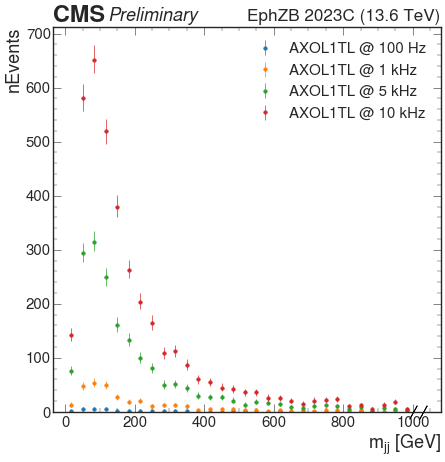

In [7]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='EphZB 2023C', com=13.6)
(mjj_result['EphZeroBias_2023C']['hists']['mJetJet_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mjj_result['EphZeroBias_2023C']['hists']['mJetJet_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mjj_result['EphZeroBias_2023C']['hists']['mJetJet_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mjj_result['EphZeroBias_2023C']['hists']['mJetJet_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 800)
# plt.yscale('log')
plt.ylabel('nEvents', loc='top')
ax.legend();

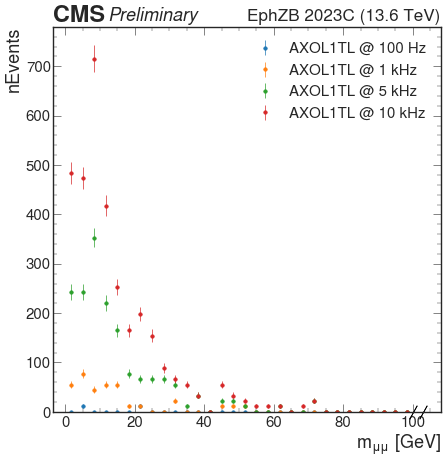

In [26]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='EphZB 2023C', com=13.6)
(mmumu_result['EphZeroBias_2023C']['hists']['mMuonMuon_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mmumu_result['EphZeroBias_2023C']['hists']['mMuonMuon_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mmumu_result['EphZeroBias_2023C']['hists']['mMuonMuon_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mmumu_result['EphZeroBias_2023C']['hists']['mMuonMuon_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 100)
# plt.yscale('log')
plt.ylabel('nEvents', loc='top')
ax.legend();

NameError: name 'mee_result' is not defined

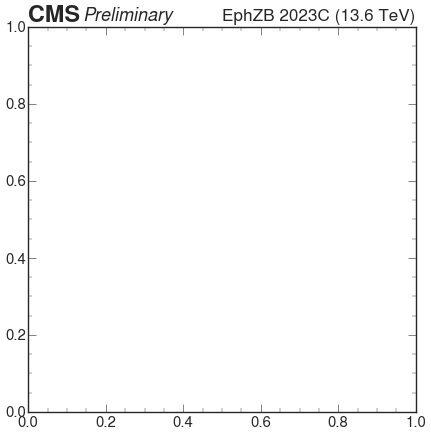

In [27]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='EphZB 2023C', com=13.6)
(mee_result['EphZeroBias_2023C']['hists']['mElectronElectron_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mee_result['EphZeroBias_2023C']['hists']['mElectronElectron_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mee_result['EphZeroBias_2023C']['hists']['mElectronElectron_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mee_result['EphZeroBias_2023C']['hists']['mElectronElectron_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 200)
plt.ylabel('nEvents', loc='top')
ax.legend();

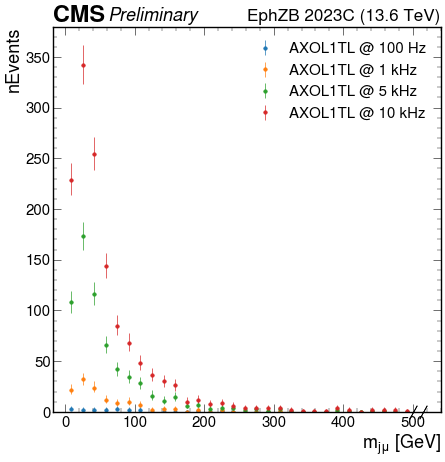

In [107]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='EphZB 2023C', com=13.6)
(mjmu_result['EphZeroBias_2023C']['hists']['mJetMuon_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mjmu_result['EphZeroBias_2023C']['hists']['mJetMuon_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mjmu_result['EphZeroBias_2023C']['hists']['mJetMuon_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mjmu_result['EphZeroBias_2023C']['hists']['mJetMuon_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 200)
plt.ylabel('nEvents', loc='top')
ax.legend();

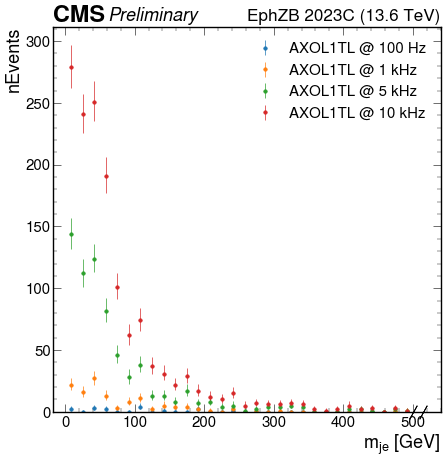

In [108]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='EphZB 2023C', com=13.6)
(mje_result['EphZeroBias_2023C']['hists']['mJetElectron_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz')
(mje_result['EphZeroBias_2023C']['hists']['mJetElectron_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz')
(mje_result['EphZeroBias_2023C']['hists']['mJetElectron_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz')
(mje_result['EphZeroBias_2023C']['hists']['mJetElectron_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz')
# ax.set_xlim(0, 200)
plt.ylabel('nEvents', loc='top')
ax.legend();

In [110]:
mjj_result.keys()

dict_keys(['EphZeroBias_2023C', 'QCD-4Jets_HT-200to400', 'VBFHToTauTau_M125', 'VBFHToInvisible_M-125', 'VBFHHto4B_CV-1_C2V-1_C3-1', 'SingleNeutrino_E-10-gun', 'JetMET0_slimmed', 'HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-500mm', 'HTo2LongLivedTo4mu_MH-125_MFF-20_CTau-13mm', 'HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm', 'HTo2LongLivedTo4b_MH-125_MFF-25_CTau-1500mm', 'HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm', 'HTo2LongLivedTo2mu2jets_MH-125_MFF-50_CTau-50mm', 'HTo2LongLivedTo2mu2jets_MH-125_MFF-20_CTau-13mm', 'HTo2LongLivedTo2mu2jets_MH-125_MFF-20_CTau-130mm', 'GluGluHToTauTau_M-125', 'GluGluHToGG_M-90', 'QCD_PT-30to80_bcToE'])

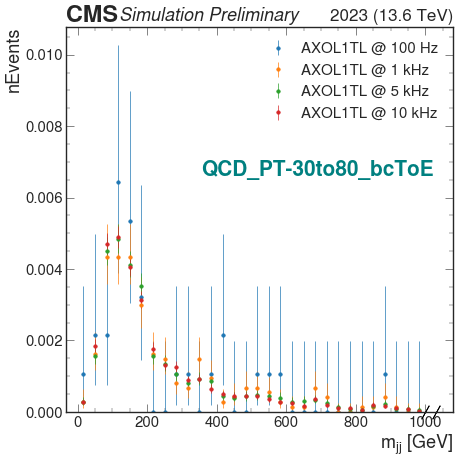

In [10]:
sample = 'QCD_PT-30to80_bcToE'
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=False, lumi=None, year='2023', com=13.6)
(mjj_result[sample]['hists']['mJetJet_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz', density=True)
(mjj_result[sample]['hists']['mJetJet_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz', density=True)
(mjj_result[sample]['hists']['mJetJet_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz', density=True)
(mjj_result[sample]['hists']['mJetJet_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz', density=True)
# ax.set_xlim(0, 800)
ax.text(0.95, 0.6, sample, fontweight='bold', transform=ax.transAxes,
        verticalalignment='bottom', horizontalalignment='right',
        color='teal', fontsize=30)
plt.ylabel('nEvents', loc='top')
ax.legend();

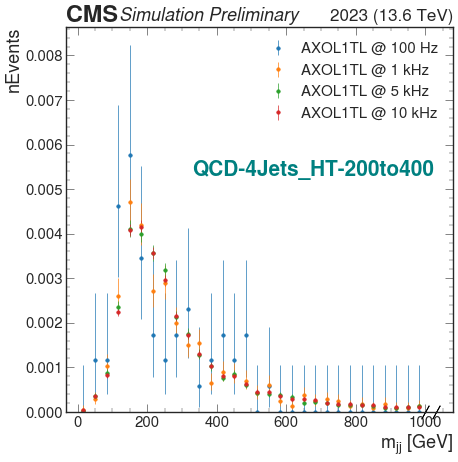

In [11]:
sample = 'QCD-4Jets_HT-200to400'
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=False, lumi=None, year='2023', com=13.6)
(mjj_result[sample]['hists']['mJetJet_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz', density=True)
(mjj_result[sample]['hists']['mJetJet_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz', density=True)
(mjj_result[sample]['hists']['mJetJet_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz', density=True)
(mjj_result[sample]['hists']['mJetJet_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz', density=True)
# ax.set_xlim(0, 800)
ax.text(0.95, 0.6, sample, fontweight='bold', transform=ax.transAxes,
        verticalalignment='bottom', horizontalalignment='right',
        color='teal', fontsize=30)
plt.ylabel('nEvents', loc='top')
ax.legend();

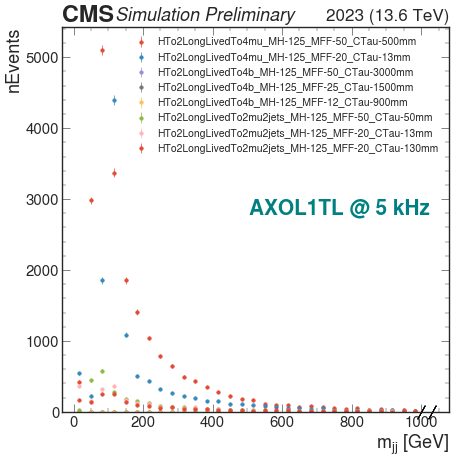

2023-12-13 19:54:47,225 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


In [160]:
samples = [s for s in mjj_result.keys() if ('HTo2LongLivedTo' in s)]
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=False, lumi=None, year='2023', com=13.6)
for s in samples:
    (mjj_result[s]['hists']['mJetJet_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label=f'{s}')
# ax.set_xlim(0, 800)
ax.text(0.95, 0.5, 'AXOL1TL @ 5 kHz', fontweight='bold', transform=ax.transAxes,
        verticalalignment='bottom', horizontalalignment='right',
        color='teal', fontsize=30)
plt.ylabel('nEvents', loc='top')
ax.legend(fontsize=15);

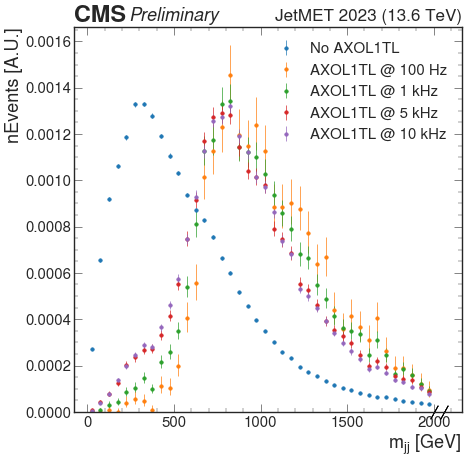

In [52]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='JetMET 2023', com=13.6)
(mjj_result['JetMET0_slimmed']['hists']['mJetJet_nocut'] * wgt).plot(ax=ax, histtype='errorbar', label='No AXOL1TL', density=True)
(mjj_result['JetMET0_slimmed']['hists']['mJetJet_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz', density=True)
(mjj_result['JetMET0_slimmed']['hists']['mJetJet_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz', density=True)
(mjj_result['JetMET0_slimmed']['hists']['mJetJet_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz', density=True)
(mjj_result['JetMET0_slimmed']['hists']['mJetJet_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz', density=True)
# ax.set_xlim(0, 200)
# plt.yscale('log')
plt.ylabel('nEvents [A.U.]', loc='top')
ax.legend();

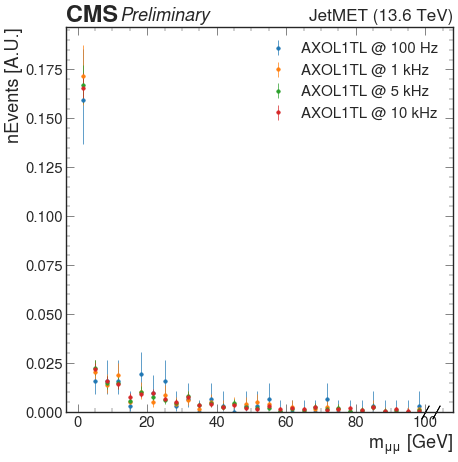

In [15]:
fig, ax = plt.subplots()
hep.cms.label('Preliminary', data=True, lumi=None, year='JetMET', com=13.6)
# (mmumu_result['JetMET0_slimmed']['hists']['mMuonMuon_nocut'] * wgt).plot(ax=ax, histtype='errorbar', label='No AXOL1TL', density=True)
(mmumu_result['JetMET0_slimmed']['hists']['mMuonMuon_100hz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 100 Hz', density=True)
(mmumu_result['JetMET0_slimmed']['hists']['mMuonMuon_1khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 1 kHz', density=True)
(mmumu_result['JetMET0_slimmed']['hists']['mMuonMuon_5khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 5 kHz', density=True)
(mmumu_result['JetMET0_slimmed']['hists']['mMuonMuon_10khz'] * wgt).plot(ax=ax, histtype='errorbar', label='AXOL1TL @ 10 kHz', density=True)
# ax.set_xlim(0, 200)
# plt.yscale('log')
plt.ylabel('nEvents [A.U.]', loc='top')
ax.legend();